In [ ]:
!pip install -q fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
import torch
import random
from PIL import Image
from fastai.vision.all import *
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = Path("/content/drive/MyDrive/FinalProject/images")

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 64

In [ ]:
print(f"Path: {DATA_PATH}")
DATA_PATH.exists()

image_files = get_image_files(DATA_PATH)
print(f"Image num: {len(image_files)}")

Path: /content/drive/MyDrive/FinalProject/images
Image num: 20000


In [ ]:
def create_sparse_color_hints(original_img_np, num_points=327, point_size=1):
    """
    Get random points and create hint from original image
    """
    h, w, c = original_img_np.shape
    hint_mask = np.zeros_like(original_img_np)

    if h <= point_size*2 or w <= point_size*2:
        return hint_mask

    for _ in range(num_points):
        y = random.randint(point_size, h - point_size - 1)
        x = random.randint(point_size, w - point_size - 1)

        y_start, y_end = max(0, y - point_size), min(h, y + point_size)
        x_start, x_end = max(0, x - point_size), min(w, x + point_size)

        hint_mask[y_start:y_end, x_start:x_end] = original_img_np[y_start:y_end, x_start:x_end]

    return hint_mask

def get_model_input(fn):

    original_img = Image.open(fn).convert('RGB')

    original_img_resized = original_img.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)

    original_img_np = np.array(original_img_resized)

    gray_img_np = cv2.cvtColor(original_img_np, cv2.COLOR_RGB2GRAY)
    hint_mask_np = create_sparse_color_hints(original_img_np)

    combined = np.concatenate([
        np.expand_dims(gray_img_np, axis=2),
        hint_mask_np
    ], axis=2)

    return torch.from_numpy(combined).permute(2, 0, 1).float() / 255.0

def get_target_image(fn):
    """Return original image as output"""
    return PILImage.create(fn)


In [ ]:
batch_tfms=aug_transforms(
    do_flip=False,
    flip_vert=False,
    max_rotate=10.0,
    max_lighting=0.2,
    max_warp=0.1,
    p_affine=0.75
)

In [ ]:
colorizer_db = DataBlock(
    blocks=(TransformBlock, ImageBlock),
    get_x=get_model_input,
    get_y=get_target_image,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(IMG_SIZE),
    batch_tfms=batch_tfms
)

dls = colorizer_db.dataloaders(image_files, bs=BATCH_SIZE)

print(f"Train batch num: {len(dls.train)}")
print(f"Val batch num: {len(dls.valid)}")

Train batch num: 250
Val batch num: 63


A.3.1. show_batch():


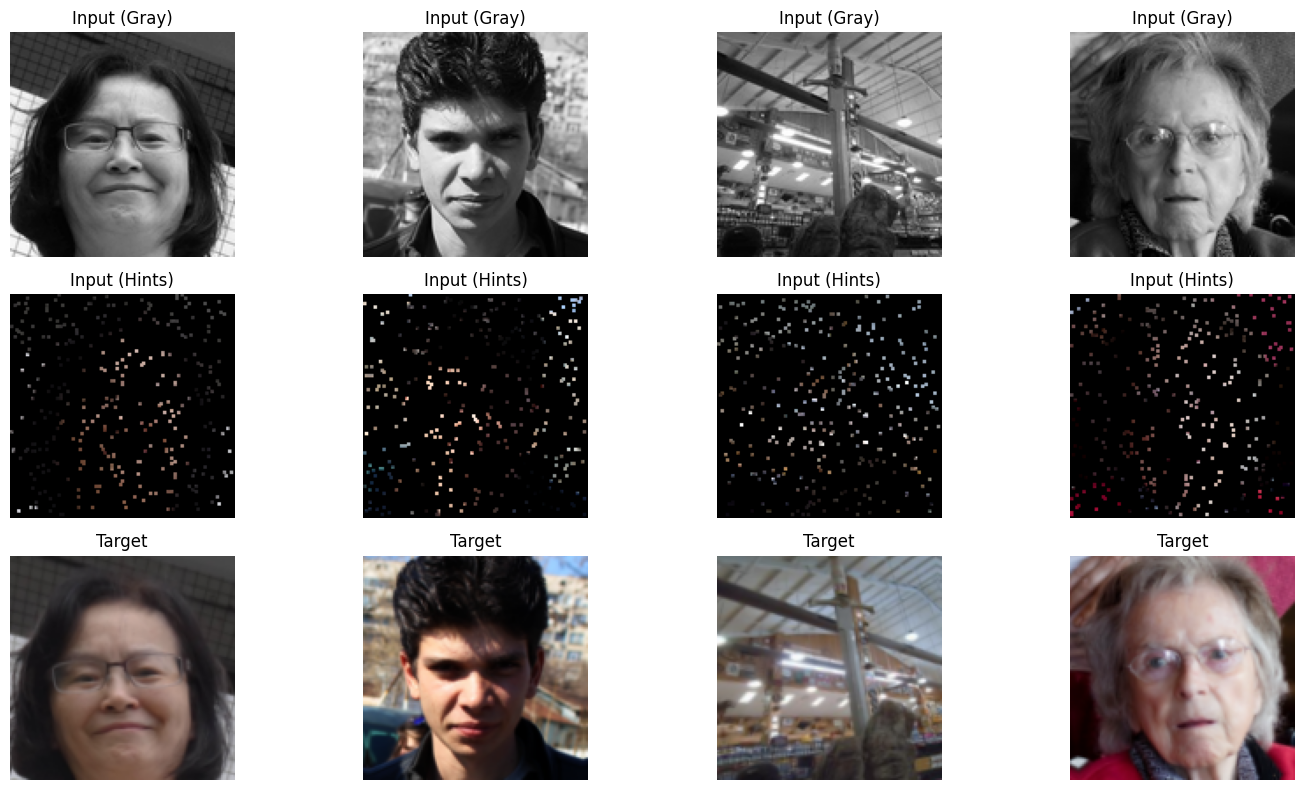

A.3.2. Veri Boyutları ve İstatistikleri
Input batch shape: torch.Size([64, 4, 128, 128])
Output batch shape: torch.Size([64, 3, 128, 128])
Input value range: [0.00, 1.00]
Output value range: [0.00, 1.00]


In [ ]:
@typedispatch
def show_batch(x:Tensor, y:TensorImage, samples, ctxs=None, max_n=6, **kwargs):
    fig, axs = plt.subplots(3, max_n, figsize=(15, 8))
    for i in range(max_n):

        axs[0, i].imshow(x[i, 0].cpu(), cmap='gray')
        axs[0, i].set_title("Input (Gray)")
        axs[0, i].axis('off')

        axs[1, i].imshow(x[i, 1:].cpu().permute(1, 2, 0))
        axs[1, i].set_title("Input (Hints)")
        axs[1, i].axis('off')

        axs[2, i].imshow(y[i].cpu().permute(1, 2, 0))
        axs[2, i].set_title("Target")
        axs[2, i].axis('off')
    plt.tight_layout()
    plt.show()
    return ctxs

dls.show_batch(max_n=4)


x, y = dls.one_batch()

print(f"Input batch shape: {x.shape}")
print(f"Output batch shape: {y.shape}")
print(f"Input value range: [{x.min():.2f}, {x.max():.2f}]")
print(f"Output value range: [{y.min().item():.2f}, {y.max().item():.2f}]")

In [ ]:
print("\n" + "="*50)
print("A.3.3. DataLoaders Özeti")
print(f"Training batches: {len(dls.train)}")
print(f"Validation batches: {len(dls.valid)}")
print(f"Batch size: {dls.bs}")
print(f"Device: {dls.device}")

print(f"Training Examples: {len(dls.train_ds)}")
print(f"Validation Examples: {len(dls.valid_ds)}")


print(f"Input dtype: {x.dtype}")
print(f"Target dtype: {y.dtype}")


print(f"After_item transforms: {dls.after_item}")
print(f"After_batch transforms: {dls.after_batch}")


print("\n" + "="*50)
print("A.3.4. Sample File Paths")
try:

    train_items = list(dls.train_ds.items)[:5]
    print("Training set examples:")
    for i, item in enumerate(train_items):
        print(f"  {i+1}. {item}")

    valid_items = list(dls.valid_ds.items)[:5]
    print("\nValidation set examples:")
    for i, item in enumerate(valid_items):
        print(f"  {i+1}. {item}")

except AttributeError:
    print("Dataset items'a erişim sağlanamadı")


print("A.3.5. Normalization")
total_samples = 0
sum_x = 0
sum_y = 0
sum_sq_x = 0
sum_sq_y = 0

for i, (x_batch, y_batch) in enumerate(dls.train):
    if i >= 10:
        break
    total_samples += x_batch.size(0)
    sum_x += x_batch.sum(dim=[0, 2, 3])
    sum_y += y_batch.sum(dim=[0, 2, 3])
    sum_sq_x += (x_batch ** 2).sum(dim=[0, 2, 3])
    sum_sq_y += (y_batch ** 2).sum(dim=[0, 2, 3])

mean_x = sum_x / (total_samples * x.shape[2] * x.shape[3])
mean_y = sum_y / (total_samples * y.shape[2] * y.shape[3])

var_x = (sum_sq_x / (total_samples * x.shape[2] * x.shape[3])) - (mean_x ** 2)
var_y = (sum_sq_y / (total_samples * y.shape[2] * y.shape[3])) - (mean_y ** 2)

std_x = torch.sqrt(var_x)
std_y = torch.sqrt(var_y)

print(f"Input channels mean: {mean_x}")
print(f"Input channels std: {std_x}")
print(f"Target channels mean: {mean_y}")
print(f"Target channels std: {std_y}")

print("\n" + "="*50)
print("Veri analizi tamamlandı!")


A.3.3. DataLoaders Özeti
Training batches: 250
Validation batches: 63
Batch size: 64
Device: cuda:0
Training Examples: 16000
Validation Examples: 4000
Input dtype: torch.float32
Target dtype: torch.float32
After_item transforms: Pipeline: Resize -- {'size': (128, 128), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor
After_batch transforms: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Warp -- {'magnitude': np.float64(0.1), 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'} -> Brightness -- {'max_lighting': np.float64(0.2), 'p': 1.0, 'draw': None, 'batch': False}

A.3.4. Sample File Paths
Training set examples:
  1. /content/drive/MyDrive/FinalProject/images/06184.jpg
  2. /content/drive/MyDrive/FinalProject/images/Places365_val_00024479.jpg
  3. /content/drive/MyDrive/Final

In [ ]:
def fine_tune_model(fine_tune_learn, NUM_EPOCHS):
  print(f"\nEpoch num: {NUM_EPOCHS}, ")
  fine_tune_learn.fine_tune(NUM_EPOCHS)
  print("Training finished.")

In [ ]:
def export_model(exported_learn, modelname):
  model_save_path = Path("/content/drive/MyDrive/FinalProject/")
  model_export_name = modelname + ".pkl"
  model_save_path.mkdir(parents=True, exist_ok=True)
  exported_learn.export(model_save_path / model_export_name)
  print(f"Model saved successfully: {model_save_path / model_export_name}")

# BENCHMARK

In [ ]:
learn_benchmark = unet_learner(
    dls,
    arch=resnet34,
    loss_func=nn.L1Loss(),
    metrics=mae,
    n_in=4,
    n_out=3
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 201MB/s]


In [ ]:
fine_tune_model(learn_benchmark, 1)


Epoch num: 1, 


Training finished.


In [ ]:
export_model(learn_benchmark, "benchmark_model")

Model saved successfully: /content/drive/MyDrive/FinalProject/benchmark_model.pkl


# EarlyStopping and resnet50

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 64

In [ ]:
learn_es_resnet50 = unet_learner(
    dls,
    arch=resnet50,
    loss_func=nn.L1Loss(),
    metrics=mae,
    n_in=4,
    n_out=3
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


In [ ]:
early_stop_cb = EarlyStoppingCallback(
    monitor='valid_loss',
    min_delta=0.0001,
    patience=10
)

suggested_lr: 9.12e-05


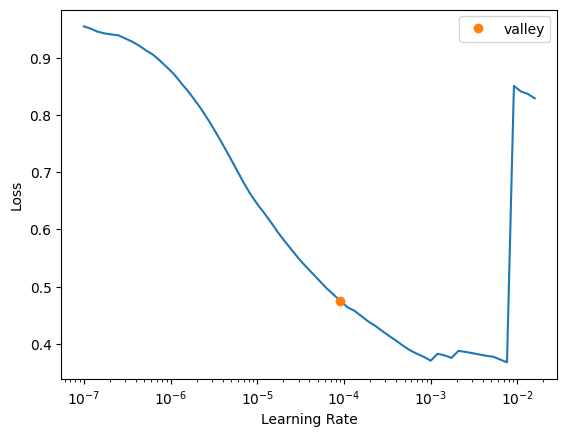

In [ ]:
lr_finder_result_head = learn_es_resnet50.lr_find()
LEARNING_RATE = lr_finder_result_head.valley
print(f"suggested_lr: {lr_finder_result_head.valley:.2e}")

In [ ]:
learn_es_resnet50.fine_tune(
    20,
    base_lr=LEARNING_RATE,
    cbs=[
        early_stop_cb,
        SaveModelCallback(monitor='valid_loss', fname='learn_es_resnet50')
    ]
)

Better model found at epoch 0 with valid_loss value: 0.07842626422643661.


Better model found at epoch 0 with valid_loss value: 0.0750972330570221.
Better model found at epoch 1 with valid_loss value: 0.06984061002731323.


Better model found at epoch 5 with valid_loss value: 0.06647178530693054.
Better model found at epoch 6 with valid_loss value: 0.06532692164182663.
Better model found at epoch 10 with valid_loss value: 0.06379938870668411.
Better model found at epoch 11 with valid_loss value: 0.0626906231045723.
Better model found at epoch 13 with valid_loss value: 0.06223326176404953.
Better model found at epoch 14 with valid_loss value: 0.061829227954149246.


In [ ]:
export_model(learn_es_resnet50, "learn_es_resnet50")

Model saved successfully: /content/drive/MyDrive/FinalProject/learn_es_resnet50.pkl


# Discriminative Learning Rates

In [ ]:
learn_dis_resnet50 = unet_learner(
    dls, arch=resnet50, loss_func=nn.L1Loss(), metrics=mae, n_in=4, n_out=3
)

In [ ]:
learn_dis_resnet50.fit_one_cycle(
    5,
    LEARNING_RATE
)

In [ ]:
learn_dis_resnet50.unfreeze()

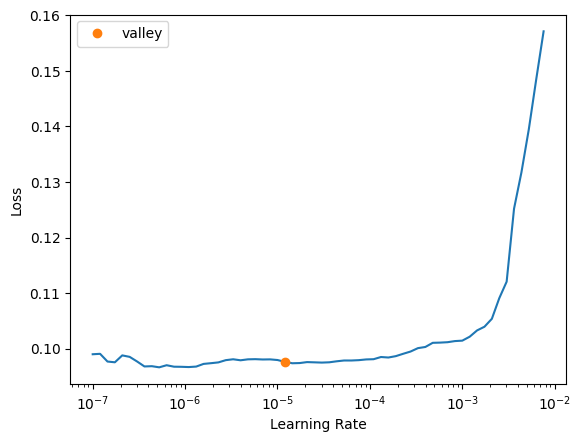

In [ ]:
lr_finder_results = learn_dis_resnet50.lr_find()

In [ ]:
# We decide start and end point manually from graph
lr_start = 1e-6  # 10^(-6)
lr_end = 1e-4    # 10^(-4)

print(f"Suggested LR range: {lr_start:.2e} to {lr_end:.2e}")

Suggested LR range: 1.00e-06 to 1.00e-04


In [ ]:
print("Training the full model with discriminative learning rates...")
learn_dis_resnet50.fit_one_cycle(
    15,
    lr_max=slice(lr_start, lr_end),
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=10),
        SaveModelCallback(monitor='valid_loss', fname='learn_dis_resnet50')
    ]
)

Training the full model with discriminative learning rates...


Better model found at epoch 0 with valid_loss value: 0.06454789638519287.
Better model found at epoch 2 with valid_loss value: 0.06370875984430313.
Better model found at epoch 4 with valid_loss value: 0.06208747252821922.
Better model found at epoch 6 with valid_loss value: 0.061868928372859955.
Better model found at epoch 8 with valid_loss value: 0.06044693663716316.
Better model found at epoch 12 with valid_loss value: 0.06035275384783745.
Better model found at epoch 13 with valid_loss value: 0.0600464753806591.


In [ ]:
export_model(learn_dis_resnet50, "learn_dis_resnet50")

Model saved successfully: /content/drive/MyDrive/FinalProject/learn_dis_resnet50.pkl


# Discriminative Learning Rates with resnet101 size is 256x256

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32

We rerun this helper function because we change batch and image size.

In [ ]:
def create_sparse_color_hints(original_img_np, num_points=1310, point_size=1):
    """
    Get random points and create hint from original image
    """
    h, w, c = original_img_np.shape
    hint_mask = np.zeros_like(original_img_np)

    if h <= point_size*2 or w <= point_size*2:
        return hint_mask

    for _ in range(num_points):
        y = random.randint(point_size, h - point_size - 1)
        x = random.randint(point_size, w - point_size - 1)

        y_start, y_end = max(0, y - point_size), min(h, y + point_size)
        x_start, x_end = max(0, x - point_size), min(w, x + point_size)

        hint_mask[y_start:y_end, x_start:x_end] = original_img_np[y_start:y_end, x_start:x_end]

    return hint_mask

def get_model_input(fn):

    original_img = Image.open(fn).convert('RGB')

    original_img_resized = original_img.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)

    original_img_np = np.array(original_img_resized)

    gray_img_np = cv2.cvtColor(original_img_np, cv2.COLOR_RGB2GRAY)
    hint_mask_np = create_sparse_color_hints(original_img_np)

    combined = np.concatenate([
        np.expand_dims(gray_img_np, axis=2),
        hint_mask_np
    ], axis=2)

    return torch.from_numpy(combined).permute(2, 0, 1).float() / 255.0

def get_target_image(fn):
    """Return original image as output"""
    return PILImage.create(fn)


In [ ]:
batch_tfms=aug_transforms(
    do_flip=False,
    flip_vert=False,
    max_rotate=10.0,
    max_lighting=0.2,
    max_warp=0.1,
    p_affine=0.75
)

In [ ]:
db_large_size = DataBlock(
    blocks=(TransformBlock, ImageBlock),
    get_x=get_model_input,
    get_y=get_target_image,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(IMG_SIZE),
    batch_tfms=batch_tfms
)

dls = db_large_size.dataloaders(image_files, bs=BATCH_SIZE)

print(f"Train batch num: {len(dls.train)}")
print(f"Val batch num: {len(dls.valid)}")

Train batch num: 500
Val batch num: 125


A.3.1. show_batch():


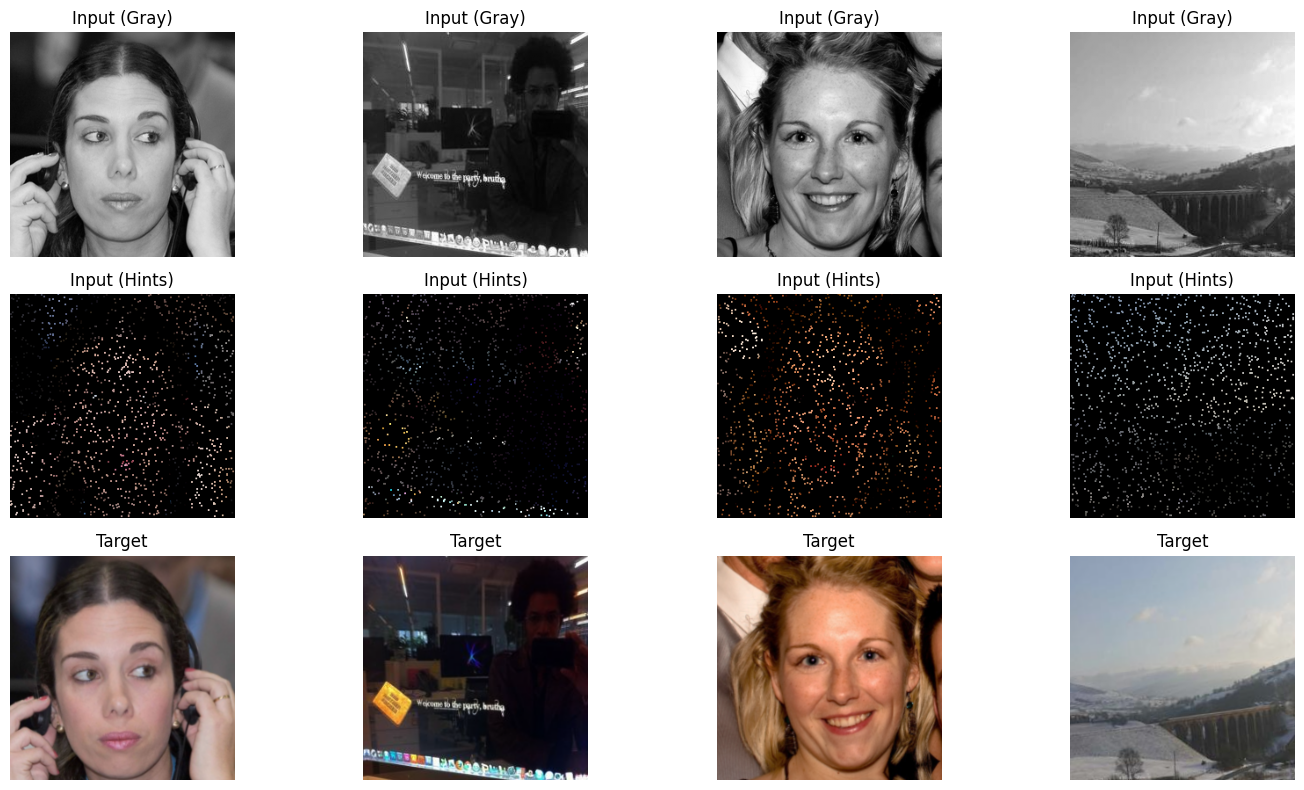

A.3.2. Veri Boyutları ve İstatistikleri
Input batch shape: torch.Size([32, 4, 256, 256])
Output batch shape: torch.Size([32, 3, 256, 256])
Input value range: [0.00, 1.00]
Output value range: [0.00, 1.00]


In [ ]:
# we use @typedispatch because all ready have show_batch function but it not work with our datablock so we create new and we want to use new show_batch function
@typedispatch
def show_batch(x:Tensor, y:TensorImage, samples, ctxs=None, max_n=6, **kwargs):
    fig, axs = plt.subplots(3, max_n, figsize=(15, 8))
    for i in range(max_n):

        axs[0, i].imshow(x[i, 0].cpu(), cmap='gray')
        axs[0, i].set_title("Input (Gray)")
        axs[0, i].axis('off')

        axs[1, i].imshow(x[i, 1:].cpu().permute(1, 2, 0))
        axs[1, i].set_title("Input (Hints)")
        axs[1, i].axis('off')

        axs[2, i].imshow(y[i].cpu().permute(1, 2, 0))
        axs[2, i].set_title("Target")
        axs[2, i].axis('off')
    plt.tight_layout()
    plt.show()
    return ctxs

print("A.3.1. show_batch():")
dls.show_batch(max_n=4)

print("A.3.2. Veri Boyutları ve İstatistikleri")
x, y = dls.one_batch()

print(f"Input batch shape: {x.shape}")
print(f"Output batch shape: {y.shape}")
print(f"Input value range: [{x.min():.2f}, {x.max():.2f}]")
print(f"Output value range: [{y.min().item():.2f}, {y.max().item():.2f}]")


In [ ]:
learn_dis_resnet101 = unet_learner(
    dls, arch=resnet101, loss_func=nn.L1Loss(), metrics=mae, n_in=4, n_out=3
)

suggested_lr: 3.63e-05


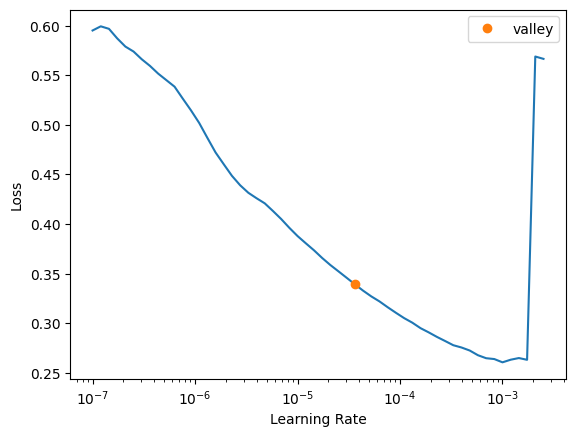

In [ ]:
lr_finder_result_head = learn_dis_resnet101.lr_find()
LEARNING_RATE = lr_finder_result_head.valley
print(f"suggested_lr: {lr_finder_result_head.valley:.2e}")

In [ ]:
learn_dis_resnet101.fit_one_cycle(
    10,
    LEARNING_RATE
)

In [ ]:
learn_dis_resnet101.unfreeze()

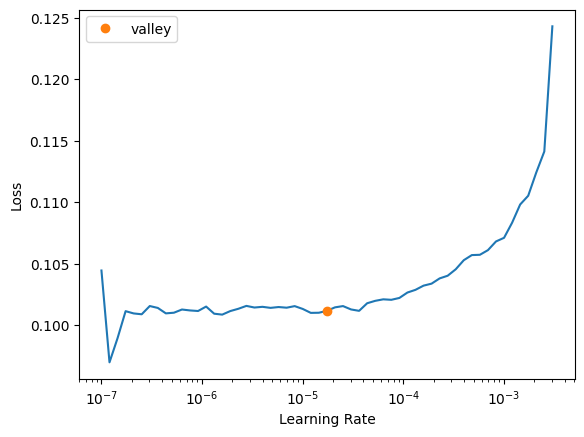

In [ ]:
lr_finder_results = learn_dis_resnet101.lr_find()

In [ ]:
# We decide start and end point manually from graph
lr_start = 1e-6  # 10^(-6)
lr_end = 5e-5   # 0.00005

print(f"Suggested LR range: {lr_start:.2e} to {lr_end:.2e}")

Suggested LR range: 1.00e-06 to 5.00e-05


In [ ]:
print("Training the full model with discriminative learning rates...")
learn_dis_resnet101.fit_one_cycle(
    20,
    lr_max=slice(lr_start, lr_end),
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=10),
        SaveModelCallback(monitor='valid_loss', fname='learn_dis_resnet101')
    ]
)

Training the full model with discriminative learning rates...


Better model found at epoch 0 with valid_loss value: 0.06824557483196259.
Better model found at epoch 2 with valid_loss value: 0.06762037426233292.


Better model found at epoch 5 with valid_loss value: 0.06653691083192825.
Better model found at epoch 7 with valid_loss value: 0.06630683690309525.


In [ ]:
export_model(learn_dis_resnet101, "learn_dis_resnet101v2")

# WITH LAB

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32

In [ ]:
def normalize_lab(lab_img):
    """normalize lab image """
    l, a, b = cv2.split(lab_img)
    l = l / 100.0
    a = (a - 128.0) / 127.0
    b = (b - 128.0) / 127.0
    return np.stack([l, a, b], axis=2).astype(np.float32)

def denormalize_lab(lab_tensor):
    """denormalize lab image to [0,255] range for transform lab image to rgb image"""
    lab_np = lab_tensor.permute(1, 2, 0).cpu().numpy()
    l, a, b = lab_np[:,:,0], lab_np[:,:,1], lab_np[:,:,2]

    l = l * 100.0
    a = a * 127.0 + 128.0
    b = b * 127.0 + 128.0

    # Ensure color values are in the [0,255] range
    lab_restored = np.stack([l, a, b], axis=2)
    lab_restored = np.clip(lab_restored, 0, 255).astype(np.uint8)
    return lab_restored

def create_sparse_color_hints(lab_img_normalized, num_points=1310):
    """Create hint witch select num_points=1310 pixel"""
    h, w, _ = lab_img_normalized.shape
    hint_mask_ab = np.zeros((h, w, 2), dtype=np.float32)

    ab_channels = lab_img_normalized[:, :, 1:]

    for _ in range(num_points):
        y = random.randint(0, h - 1)
        x = random.randint(0, w - 1)
        hint_mask_ab[y, x, :] = ab_channels[y, x, :]

    return hint_mask_ab

In [ ]:
def get_model_input(fn, p_hints=0.5):
    """
    Create model inputs, add hints to grayscale image in 0.5 probablity
    """
    original_img = Image.open(fn).convert('RGB')
    original_img_resized = original_img.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
    original_img_np = np.array(original_img_resized)

    lab_img = cv2.cvtColor(original_img_np, cv2.COLOR_RGB2LAB)
    lab_img_normalized = normalize_lab(lab_img)

    l_channel = lab_img_normalized[:, :, 0:1]

    if random.random() < p_hints:
        hint_mask_ab = create_sparse_color_hints(lab_img_normalized)
    else:
        # If not add hint assign 0 to all hint mask
        hint_mask_ab = np.zeros((IMG_SIZE, IMG_SIZE, 2), dtype=np.float32)


    # concatenate grayscale and hints
    combined = np.concatenate([hint_mask_ab, l_channel], axis=2)
    return torch.from_numpy(combined).permute(2, 0, 1).float()

def get_target_image(fn):
    original_img = Image.open(fn).convert('RGB')
    original_img_resized = original_img.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
    original_img_np = np.array(original_img_resized)

    lab_img = cv2.cvtColor(original_img_np, cv2.COLOR_RGB2LAB)
    lab_img_normalized = normalize_lab(lab_img)

    # Our target just A and B channels
    ab_channels = lab_img_normalized[:, :, 1:]
    return torch.from_numpy(ab_channels).permute(2, 0, 1).float()

In [ ]:
batch_tfms=aug_transforms(
    do_flip=False,
    flip_vert=False,
    max_rotate=10.0,
    max_lighting=0.2,
    max_warp=0.1,
    p_affine=0.75
)

In [ ]:
db_lab = DataBlock(
    blocks=(TransformBlock, TransformBlock),
    get_x=get_model_input,
    get_y=get_target_image,
    splitter=RandomSplitter(valid_pct=0.15, seed=42),
    batch_tfms=batch_tfms
)

dls = db_lab.dataloaders(image_files, bs=BATCH_SIZE)

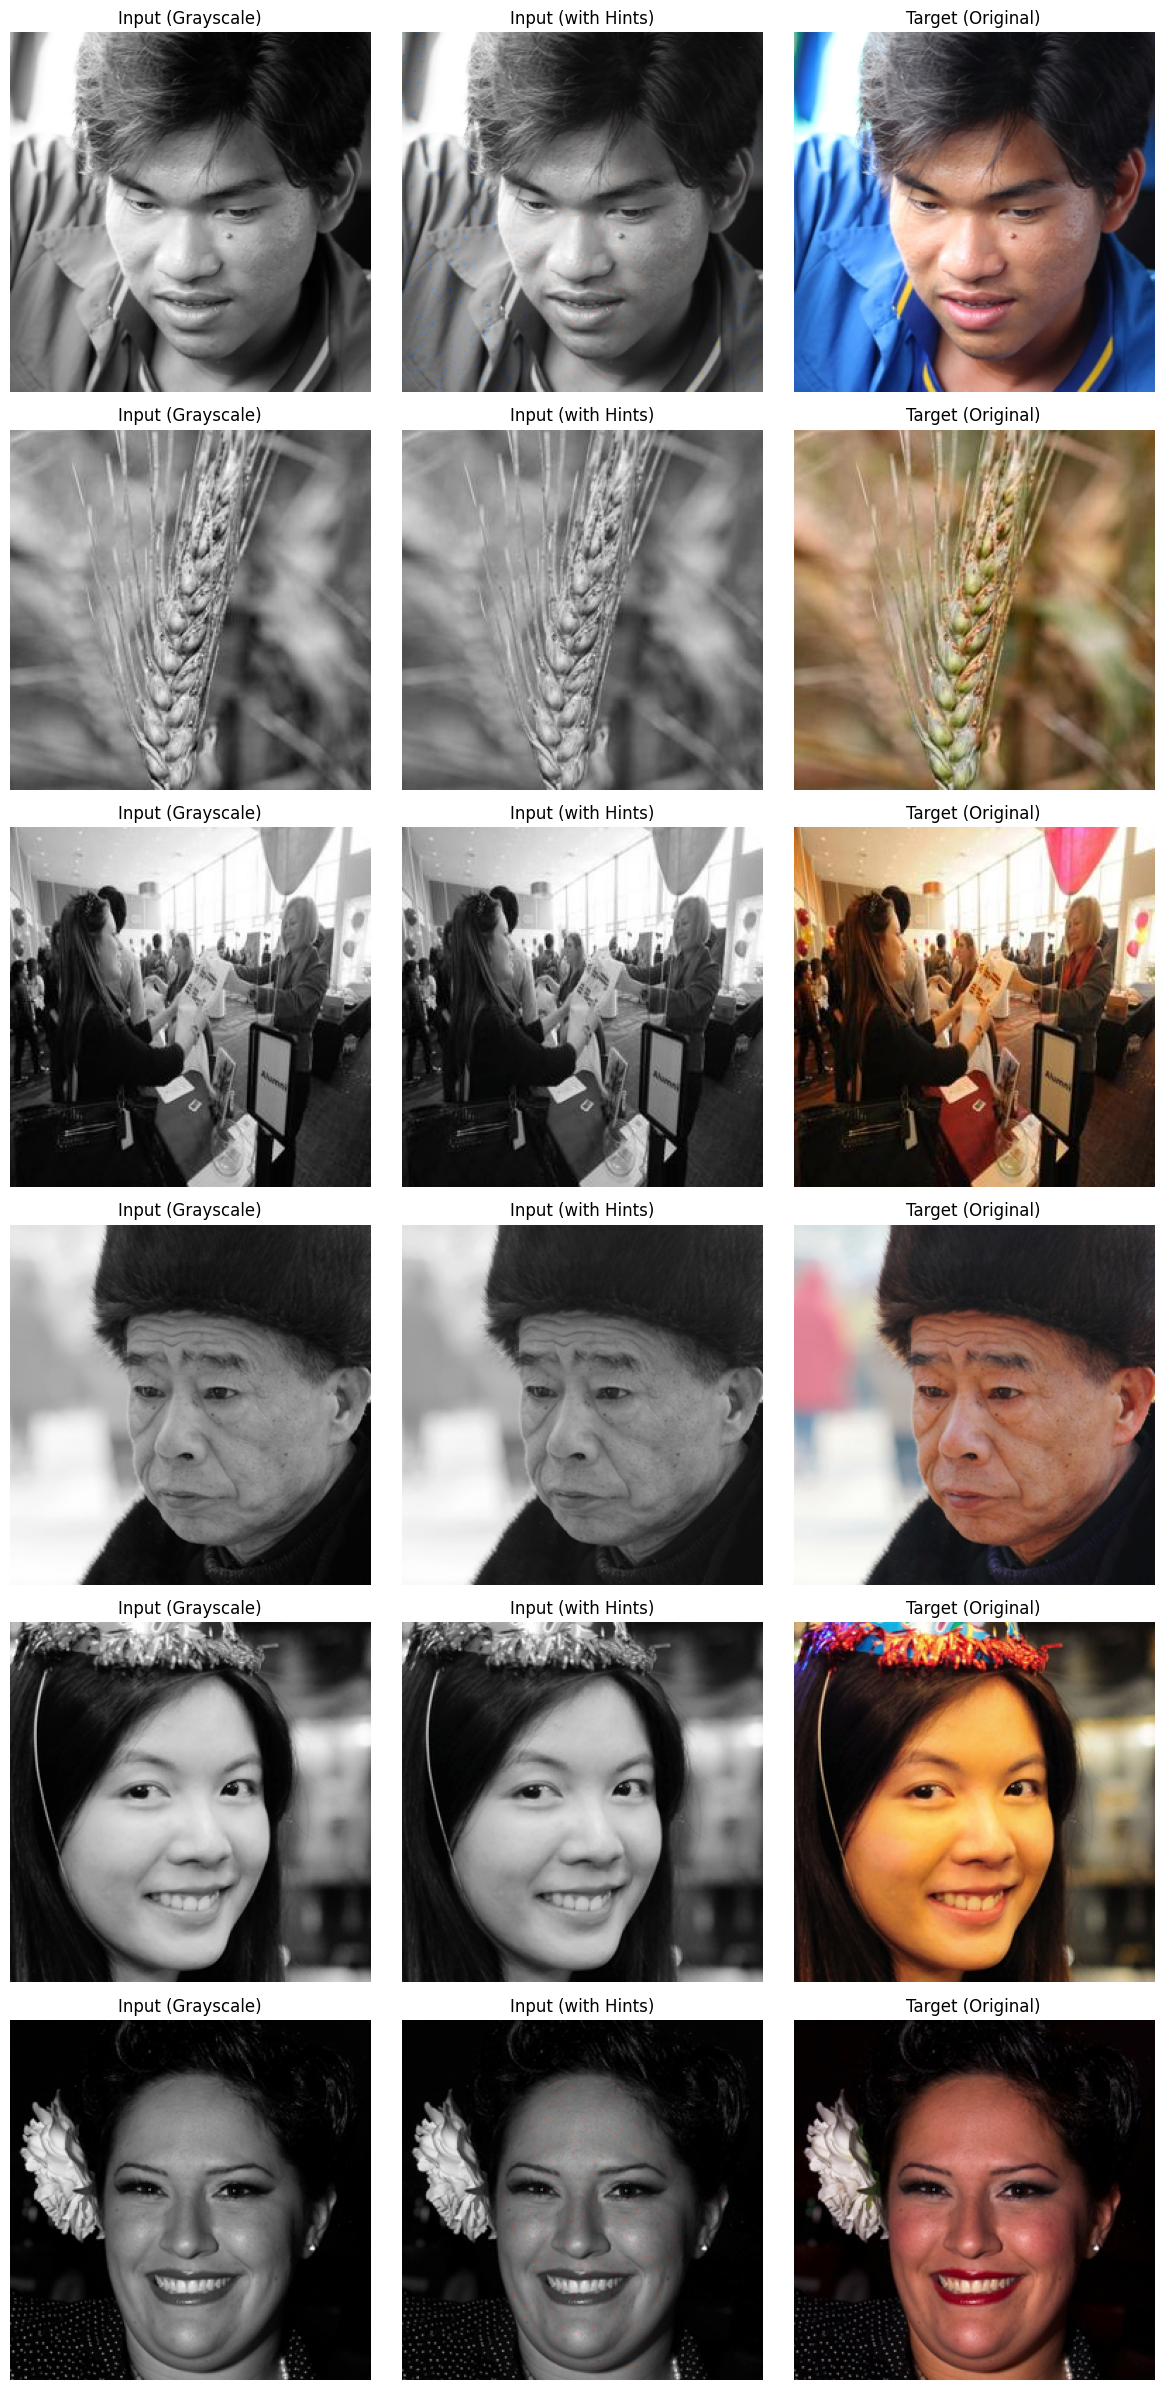

In [ ]:
@typedispatch
def show_batch(x: Tensor, y: Tensor, samples, ctxs=None, max_n=6, **kwargs):

    def denormalize_lab_local(lab_tensor):
        lab_np = lab_tensor.permute(1, 2, 0).cpu().numpy()
        l, a, b = lab_np[:,:,0], lab_np[:,:,1], lab_np[:,:,2]
        l = l * 100.0
        a = a * 127.0 + 128.0
        b = b * 127.0 + 128.0
        lab_restored = np.stack([l, a, b], axis=2)
        return np.clip(lab_restored, 0, 255).astype(np.uint8)

    fig, axs = plt.subplots(max_n, 3, figsize=(12, max_n * 4))
    if max_n == 1:
        axs = np.expand_dims(axs, axis=0)

    for i in range(max_n):

        l_channel_input = x[i, 2].cpu()
        axs[i, 0].imshow(l_channel_input, cmap='gray')
        axs[i, 0].set_title("Input (Grayscale)")
        axs[i, 0].axis('off')

        input_with_hints_lab_tensor = torch.cat([
            x[i, 2:3],
            x[i, 0:2]
        ], dim=0)

        input_with_hints_denorm = denormalize_lab_local(input_with_hints_lab_tensor)
        input_with_hints_rgb = cv2.cvtColor(input_with_hints_denorm, cv2.COLOR_LAB2RGB)
        axs[i, 1].imshow(input_with_hints_rgb)
        axs[i, 1].set_title("Input (with Hints)")
        axs[i, 1].axis('off')


        target_lab_tensor = torch.cat([
            x[i, 2:3],
            y[i]
        ], dim=0)

        target_denorm = denormalize_lab_local(target_lab_tensor)
        target_rgb = cv2.cvtColor(target_denorm, cv2.COLOR_LAB2RGB)
        axs[i, 2].imshow(target_rgb)
        axs[i, 2].set_title("Target (Original)")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()
    return ctxs

dls.show_batch(max_n=6)

# Model Training with LAB

Resnet34

In [ ]:
learn = unet_learner(
    dls,
    arch=resnet34,
    loss_func=nn.L1Loss(),
    metrics=mae,
    n_in=3,
    n_out=2,
    self_attention=True,
)

suggested_lr: 9.12e-05


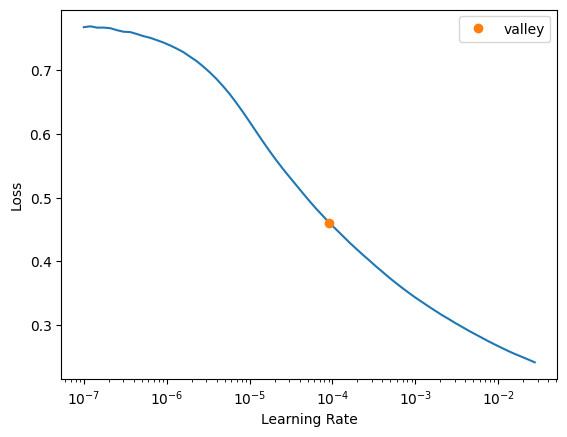

In [ ]:
lr_finder_result_head = learn.lr_find()
LEARNING_RATE = lr_finder_result_head.valley
print(f"suggested_lr: {lr_finder_result_head.valley:.2e}")

In [ ]:
learn.fit_one_cycle(
    10,
    LEARNING_RATE
)

In [ ]:
learn.unfreeze()

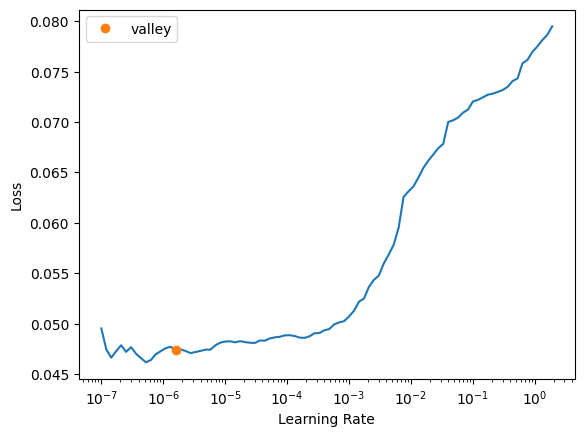

In [ ]:
lr_finder_results = learn.lr_find()

In [ ]:
# We decide start and end point manually from graph
lr_start = 5.25e-05  # 5.25×10−5
lr_end = 1e-4   # 10^(-4)

print(f"Suggested LR range: {lr_start:.2e} to {lr_end:.2e}")

Suggested LR range: 5.25e-05 to 1.00e-04


In [ ]:
print("Training the full model with discriminative learning rates...")
learn.fit_one_cycle(
    20,
    lr_max=slice(lr_start, lr_end),
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0005, patience=10),
        SaveModelCallback(monitor='valid_loss', fname='learn')
    ]
)

Training the full model with discriminative learning rates...


Better model found at epoch 0 with valid_loss value: 0.05040578171610832.
Better model found at epoch 1 with valid_loss value: 0.049886662513017654.
Better model found at epoch 2 with valid_loss value: 0.04889431223273277.
Better model found at epoch 4 with valid_loss value: 0.04723360016942024.
Better model found at epoch 6 with valid_loss value: 0.04617670550942421.
Better model found at epoch 7 with valid_loss value: 0.045637018978595734.
Better model found at epoch 8 with valid_loss value: 0.0454566590487957.
Better model found at epoch 9 with valid_loss value: 0.04475153610110283.
Better model found at epoch 10 with valid_loss value: 0.04463714733719826.
Better model found at epoch 11 with valid_loss value: 0.044167764484882355.
Better model found at epoch 13 with valid_loss value: 0.04303506016731262.
Better model found at epoch 16 with valid_loss value: 0.043024204671382904.


In [ ]:
export_model(learn, "learn_new_approach")

Model saved successfully: /content/drive/MyDrive/FinalProject/learn_new_approach.pkl


resnet50

In [ ]:
learn_renset50 = unet_learner(
    dls,
    arch=resnet50,
    loss_func=nn.L1Loss(),
    metrics=mae,
    n_in=3,
    n_out=2,
    self_attention=True,
)

suggested_lr: 5.25e-05


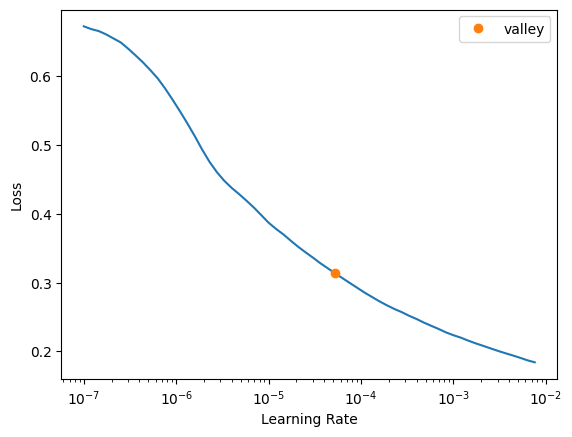

In [ ]:

lr_finder_result_head = learn_renset50.lr_find()
LEARNING_RATE = lr_finder_result_head.valley
print(f"suggested_lr: {lr_finder_result_head.valley:.2e}")

In [ ]:
learn_renset50.fit_one_cycle(
    5,
    LEARNING_RATE
)

In [ ]:
learn_renset50.unfreeze()

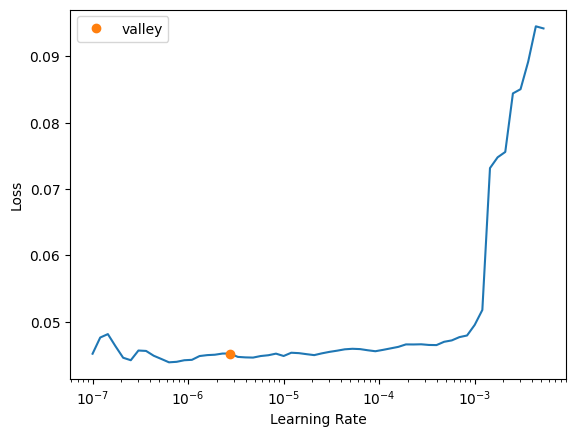

In [ ]:
lr_finder_results = learn_renset50.lr_find()

In [ ]:
# We decide start and end point manually from graph
lr_start = 1e-6  # 10^(-6)
lr_end = 1e-4   # 10^(-4)

print(f"Suggested LR range: {lr_start:.2e} to {lr_end:.2e}")

Suggested LR range: 1.00e-06 to 1.00e-04


In [ ]:
print("Training the full model with discriminative learning rates...")
learn_renset50.fit_one_cycle(
    10,
    lr_max=slice(lr_start, lr_end),
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0005, patience=10),
        SaveModelCallback(monitor='valid_loss', fname='learn')
    ]
)

Training the full model with discriminative learning rates...


Better model found at epoch 0 with valid_loss value: 0.04688176140189171.
Better model found at epoch 2 with valid_loss value: 0.0449199378490448.
Better model found at epoch 3 with valid_loss value: 0.044504713267087936.
Better model found at epoch 5 with valid_loss value: 0.0435674674808979.
Better model found at epoch 6 with valid_loss value: 0.042484499514102936.
Better model found at epoch 7 with valid_loss value: 0.04225235432386398.
Better model found at epoch 8 with valid_loss value: 0.04224840924143791.
Better model found at epoch 9 with valid_loss value: 0.04167449474334717.


In [ ]:
export_model(learn_renset50, "learn_renset50")

Model saved successfully: /content/drive/MyDrive/FinalProject/learn_renset50.pkl
